# Analysis of differential expression across conditions

* Temperature: 10, 18, 25, 34
* Lighting: Dark, Light

__NOTES__:

1. So far I have computed DE among all samples disregarding effect of day cycle. I would need to compute DE between light and dark conditions, as well as DE for temperature for the two independent data sets (light, dark)
2. Regarding the two effects, I could find genes:

Condition | Temp (10 -> 34) 
--- | ---
Light | (+, -) 
Dark | (+, -) 

Hence, would be interesting to cluster genes based on the DE pattern, i.e., those which correlate with temperatur in the same manner under light or dark and those that differ...

3. Need also to establish which condition generates more variance: lighting or temperature?

In [178]:
import pandas as pd
from diffexpr.py_deseq import py_DESeq2
from rpy2.robjects import Formula
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR) 

counts = pd.read_csv('Data/DokdoniaCounts.csv', index_col=0)
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts.head()

,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3_T1,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4_T1,L_34_R4_T2,L_34_R4_T3,L_34_R4
MED134_07389,12973,11426,13251,30624,30618,25566,41014,22449,53840,32369,...,39444,41721,37020,39662,30983,27280,43105,44946,39311,57834
MED134_07384,1557,1555,1552,4160,4385,3383,5588,2940,7550,4509,...,5419,5536,5318,5396,4751,4285,5108,4924,4503,7818
MED134_07379,3400,3319,3273,7218,7903,6315,9539,5040,13268,7572,...,9089,9016,8529,10179,7617,7207,9484,8837,8743,13827
MED134_07374,1987,2124,1404,3509,3772,2846,4337,2602,4607,3316,...,3586,3594,3488,4158,3096,2623,3818,3792,3538,5323
MED134_07369,2087,2010,2111,3774,3809,2921,4486,2901,4668,3456,...,3705,4158,3760,5518,3563,2713,3679,3543,3356,5150


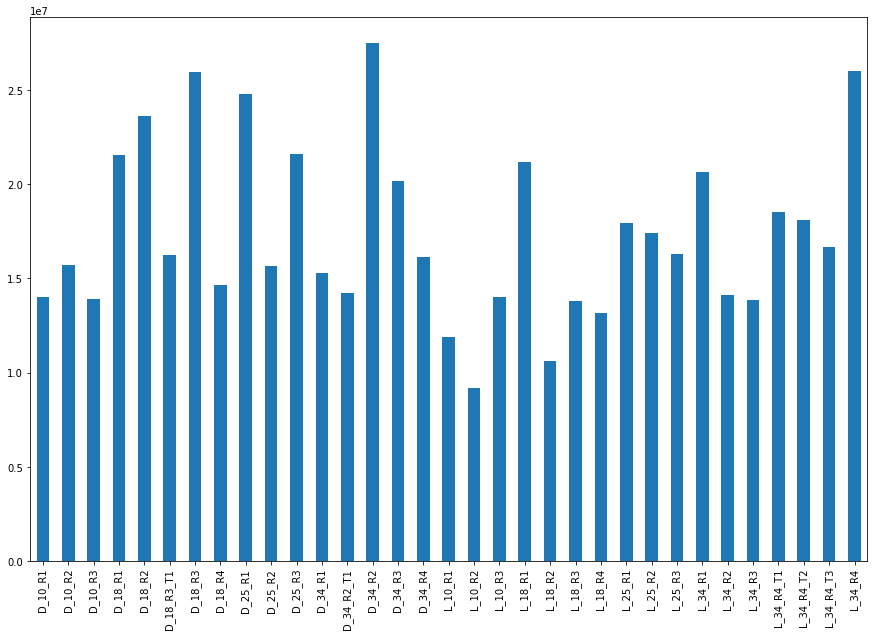

In [8]:
ax = counts.sum().plot.bar(figsize=(15, 10))

In [179]:
# Removing genes with low read counts across samples
min_count = 10
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
counts.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3_T1,D_18_R3,D_18_R4,D_25_R1,...,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4_T1,L_34_R4_T2,L_34_R4_T3,L_34_R4
0,MED134_07389,12973,11426,13251,30624,30618,25566,41014,22449,53840,...,39444,41721,37020,39662,30983,27280,43105,44946,39311,57834
1,MED134_07384,1557,1555,1552,4160,4385,3383,5588,2940,7550,...,5419,5536,5318,5396,4751,4285,5108,4924,4503,7818
2,MED134_07379,3400,3319,3273,7218,7903,6315,9539,5040,13268,...,9089,9016,8529,10179,7617,7207,9484,8837,8743,13827
3,MED134_07374,1987,2124,1404,3509,3772,2846,4337,2602,4607,...,3586,3594,3488,4158,3096,2623,3818,3792,3538,5323
4,MED134_07369,2087,2010,2111,3774,3809,2921,4486,2901,4668,...,3705,4158,3760,5518,3563,2713,3679,3543,3356,5150


In [180]:
meta = pd.DataFrame({
    'lighting': [s[0] for s in conditions],
    'temperature': [s[2:4] for s in conditions],
    'replicate': [s[5:] for s in conditions]
    }, index=conditions)
meta.head()

,lighting,temperature,replicate
D_10_R1,D,10,R1
D_10_R2,D,10,R2
D_10_R3,D,10,R3
D_18_R1,D,18,R1
D_18_R2,D,18,R2


In [263]:
p_value_cutoff = 5e-2

dds = py_DESeq2(count_matrix = counts,
               design_matrix = meta,
               design_formula = '~ temperature',
               gene_column = 'index')
    
dds.run_deseq(test="LRT", reduced = Formula('~ 1')) 
dds.get_deseq_result(alpha=p_value_cutoff)
res = dds.deseq_result 
res = res[res.padj < p_value_cutoff]
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,index
MED134_07389,28703.140067,0.943521,0.075685,180.213823,7.930304e-39,3.610045e-38,MED134_07389
MED134_07384,3910.065668,1.131689,0.059654,400.655552,1.596459e-86,2.240494e-85,MED134_07384
MED134_07379,6943.980527,0.905642,0.044703,471.521169,7.080892e-102,1.273233e-100,MED134_07379
MED134_07374,2984.962379,0.366559,0.064449,51.038015,4.801699e-11,8.449227e-11,MED134_07374
MED134_07369,3263.281489,0.206131,0.085757,17.076457,6.816086e-04,8.204970e-04,MED134_07369


In [188]:
neg_corr_genes = res[res.log2FoldChange < -1].index.tolist()
pos_corr_genes = res[res.log2FoldChange > 1].index.tolist()

In [11]:
# dds.result_summary()

## Taking a look at selected genes with high log2 fold change

In [183]:
tpm = pd.read_csv('Data/tpm_counts.csv', index_col=0)
tpm.head()

,D_10_R1.sam,D_10_R2.sam,D_10_R3.sam,D_18_R1.sam,D_18_R2.sam,D_18_R3_T1.sam,D_18_R3.sam,D_18_R4.sam,D_25_R1.sam,D_25_R2.sam,...,L_25_R1.sam,L_25_R2.sam,L_25_R3.sam,L_34_R1.sam,L_34_R2.sam,L_34_R3.sam,L_34_R4_T1.sam,L_34_R4_T2.sam,L_34_R4_T3.sam,L_34_R4.sam
MED134_07389,126.651810,103.199290,132.954350,207.076817,186.093462,230.692835,232.104483,217.039083,319.508620,287.121249,...,309.890336,332.917481,319.950739,279.889139,329.788952,298.880372,360.335351,386.297760,364.639362,342.590660
MED134_07384,93.133592,86.051736,95.409665,172.349350,163.294159,187.033790,193.755730,174.154632,274.518258,245.054704,...,260.851290,270.660405,281.605927,233.308269,309.844950,287.640881,261.623569,259.296074,255.916424,283.749242
MED134_07379,98.558447,89.008953,97.508810,144.920691,142.623218,169.195430,160.286964,144.682310,233.790545,199.430055,...,212.025033,213.618935,218.871276,213.285093,240.735725,234.450684,235.404478,225.517345,240.798561,243.200355
MED134_07374,216.411361,214.016968,157.156450,264.706216,255.762687,286.495249,273.811718,280.646379,305.004991,328.141969,...,314.303035,319.941937,336.305821,327.346067,367.641724,320.599267,356.062594,363.588951,366.115816,351.770941
MED134_07369,287.031906,255.749791,298.386295,359.507705,326.138456,371.312544,357.641093,395.116727,390.251982,431.863528,...,410.064372,467.415509,457.795258,548.567247,534.275427,418.735291,433.257163,428.981967,438.538927,429.770161


Evaluating gene: MED134_08511


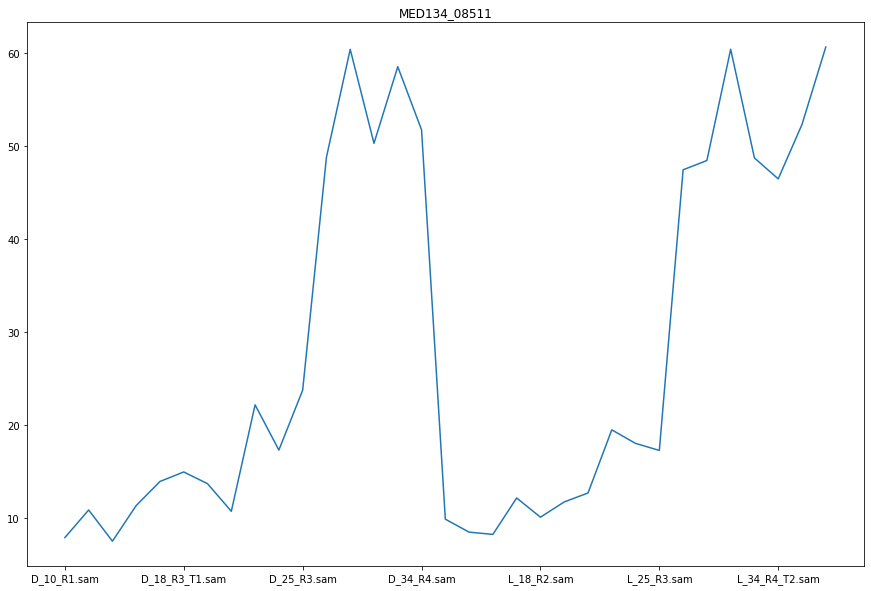

In [184]:
gene_id = pos_corr_genes[30]
print(f'Evaluating gene: {gene_id}')
ax = tpm.loc[gene_id].plot(legend=False, figsize=(15, 10), title=gene_id)

Evaluating gene: MED134_05724


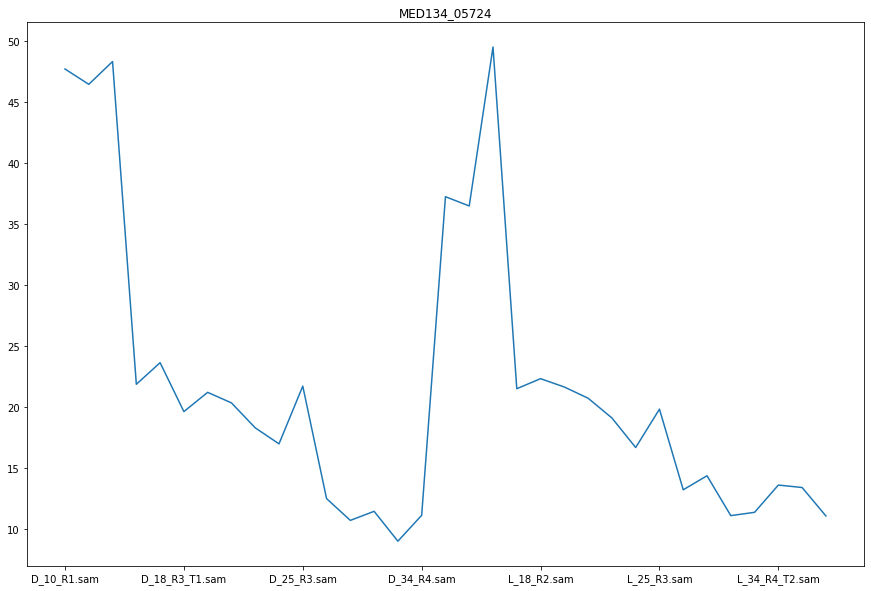

In [52]:
gene_id = neg_corr_genes[5]
print(f'Evaluating gene: {gene_id}')
ax = tpm.loc[gene_id].plot(legend=False, figsize=(15, 10), title=gene_id)

## Parse GBK file

In [257]:
from Bio import SeqIO

class GenomeGBK:

    def __init__(self, path_to_gbk):
        self._gbk = list(SeqIO.parse(path_to_gbk, 'genbank'))[0]
    
    @property
    def meta(self):
        return dict(self._gbk.features[0].qualifiers)
    
    def getGeneInfo(self, gene_id: str):
        try:
            gene, cds = [f for f in self._gbk.features[1:] if gene_id.lower() in f.qualifiers['locus_tag'][0].lower()]
            res = dict(cds.qualifiers); res.update({'location': gene.location})
            return res
        except Exception:
            raise ValueError(f'Gene {gene_id} not found in GBK') 
    
    def has_EC_number(self, gene_id: str):
        return 'EC_number' in self.getGeneInfo(gene_id).keys()
    
    def getEnzymeGene(self, ec_number: str):
        try:
            return [f.qualifiers['locus_tag'][0] for f in self._gbk.features[1:] if ('EC_number' in f.qualifiers.keys() 
                                                                                      and ec_number in f.qualifiers['EC_number'][0])]
        except Exception:
             raise ValueError(f'Enzyme {ec_number} not found in GBK') 

In [258]:
gbk = GenomeGBK('Data/DokdoniaMED134.gbk')
gbk.meta

{'organism': ['Dokdonia sp. MED134'],
 'mol_type': ['genomic DNA'],
 'strain': ['MED134'],
 'isolation_source': ['collected at a depth of 1 meter; isolated by plating on solid media'],
 'db_xref': ['taxon:313590'],
 'country': ['Mediterranean Sea']}

In [255]:
gene_id = 'MED134_07089' # THe EC corresponds to adenylate cyclase... however protein EAQ40501.1 has no annotation 
gbk.getGeneInfo(gene_id)

{'locus_tag': ['MED134_07089'],
 'EC_number': ['4.6.1.1'],
 'codon_start': ['1'],
 'transl_table': ['11'],
 'product': ['sensor of blue-light using FAD'],
 'protein_id': ['EAQ40501.1'],
 'translation': ['MYTICYLSKVSPHLTETQIQEIFDHTYAQNNKKGICGILLHTMGNFFQVLEGDEAYLTDLYENRIKKDPRHHSIFEVIHKEGSDPVFTSYSSRFLTIEDSDALNDIKTYVKKHAVVSSTSDKIARLLNTVEMLTY'],
 'location': FeatureLocation(ExactPosition(67655), ExactPosition(68063), strand=-1)}

In [260]:
# Trying out ec finder
gbk.getEnzymeGene('2.7.1.40')

['MED134_09046']

Evaluating gene: MED134_09046


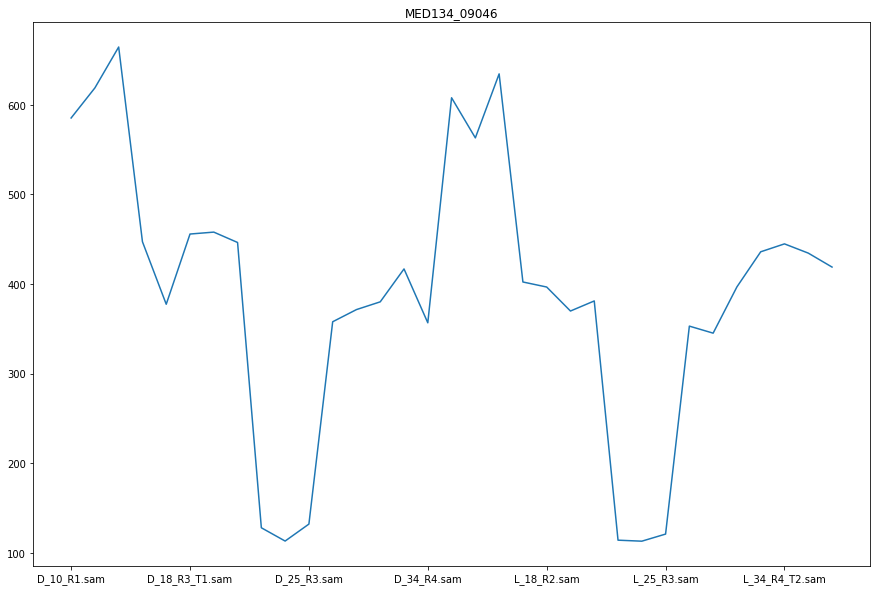

In [261]:
gene_id = gbk.getEnzymeGene('2.7.1.40')[0]
print(f'Evaluating gene: {gene_id}')
ax = tpm.loc[gene_id].plot(legend=False, figsize=(15, 10), title=gene_id)

In [265]:
res[gene_id] # Weird that this one is not among DE... perhaps because only comparing 34 vs 10 degress...

## Finding metabolic genes (EC number) among DE

In [191]:
met_pos_genes = [gene_id for gene_id in pos_corr_genes if gbk.has_EC_number(gene_id)]
met_neg_genes = [gene_id for gene_id in neg_corr_genes if gbk.has_EC_number(gene_id)]
print(f'There are: {len(met_pos_genes)} positive genes with EC and {len(met_neg_genes)} negative')

There are: 22 positive genes with EC and 42 negative


In [194]:
# Which enzymes are negatively correlated with temperature?
print([gbk.getGeneInfo(gene_id)['product'][0] for gene_id in met_neg_genes])

['6-phosphofructokinase', 'glyceraldehyde-3-phosphate dehydrogenase A', 'phosphoribosylformylglycinamidine synthase', 'imidazole glycerol phosphate synthase subunit HisF', 'methylmalonyl-CoA mutase', 'glutamate-ammonia ligase', 'propionyl-CoA carboxylase beta chain', 'two-component system sensor histidine kinase', 'DNA-directed RNA polymerase beta chain', 'prephenate dehydratase', 'tRNA-guanine transglycosylase', 'NADH dehydrogenase', 'O-acetylhomoserineaminocarboxypropyltransferase', 'inorganic pyrophosphatase', 'ATP-dependent Clp protease proteolytic subunit', 'FKBP-type peptidyl-prolyl cis-transisomerase', 'glycogen synthase', 'ribose-phosphate pyrophosphokinase', '3-oxoacid CoA-transferase, B subunit', '3-oxoacid CoA-transferase, A subunit', 'pyruvate kinase', 'amidophosphoribosyltransferase', 'choline dehydrogenase', 'glutamate dehydrogenase', 'sulfate permease', 'saccharopine dehydrogenase (NADP+, L-glutamate forming)', 'crossover junction endodeoxyribonuclease RuvC', 'oxygen-ind

In [195]:
# Which enzymes are positively correlated with temperature?
print([gbk.getGeneInfo(gene_id)['product'][0] for gene_id in met_pos_genes])

['sensor of blue-light using FAD', 'oligo-1,6-glucosidase', 'hydroxymethylglutaryl-CoA lyase', 'pyruvate carboxylase', 'glyceraldehyde-3-phosphate dehydrogenase A', 'isocitrate lyase', 'malate synthase', 'two-component system sensor histidine kinase', 'Asp/Glu/hydantoin racemase', 'D-amino acid dehydrogenase small subunit', 'proline racemase', 'catalase/peroxidase HPI', 'peptide-methionine (S)-S-oxide reductase', 'phosphoenolpyruvate carboxykinase (ATP)', '2-dehydro-3-deoxygluconokinase', 'alginate lyase precursor', 'alginate lyase', 'ribonuclease HII', 'pyrimidine operon attenuation protein / uracil phosphoribosyltransferase', 'two-component system sensor histidine kinase', 'sulfate adenylyltransferase subunit 2', 'sulfate adenylyltransferase subunit 1']


## Connecting expression to metabolism
* Identify genes coding for enzymes
* Get thermodynamic information for the reaction (equilibrator)
These would give an idea of which reactions may be happening as well as the direction of flow

# Notes on possible errors in annotation
1. MED134_07089: The EC number corresponds to [adenylate cyclase](https://www.brenda-enzymes.org/enzyme.php?ecno=4.6.1.1) however protein [EAQ40501.1](https://string-db.org/network/313590.MED134_07089) isn't annotated, and the product description is "sensor of blue light using FAD". After searching for EC number ('4.6.1.1') I found another gene: MED134_03369, which seems to be the true adenylate cyclase!.